In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import shutil
import os
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

### Since random seeds are not fixed, "Generating datasets" will overwrite the dataset in data/synthetic. If you want to run the experiment on the same dataset as the paper, please start from Estimation.

### Generating datasets

In [77]:
def generate_phi(K, D, alpha):
    phi = np.zeros((K, D+1, D))
    for k in range(K):
        for i in range(D):
            phi[k, i, i] = - abs(np.random.normal(0, alpha))
            phi[k, -1, :] = abs(np.random.normal(0, alpha, size=D))
    for k in range(K):
        for i in range(D):
            for j in range(D):
                if i != j:
                    phi[k, i, j] = np.random.normal(0, alpha)
    return phi

In [78]:
def generate_z(state_type, N):
    z = np.zeros(N, dtype=int)
    if state_type == 'One-switching':
        sep = len(z)//2
        z[:sep] = 0
        z[sep:] = 1
    elif state_type == 'One-state':
        pass
    return z

In [79]:
def generate_x(N, D, phi, z, timepoints, step, noize):
    x_init = np.random.gamma(1, 1, size=D)
    print(x_init)
    x = np.zeros((D, N))
    x[:,0] = x_init
    delta_lnx_list = []
    for i, timepoint in enumerate(timepoints):
        if i+1 < len(timepoints):
            k = z[i]
            dlnxdt = np.dot(phi[k, :-1, :].T, x[:, i]) + phi[k, -1, :]
            delta_t = timepoints[i+1] - timepoints[i]
            delta_lnx = dlnxdt * delta_t
            delta_lnx_list.append(delta_lnx)
            x[:, i+1] = np.exp(np.log(x[:, i]) + delta_lnx)
    x_df = pd.DataFrame(x[:, ::step])
    if noize > 0:
        ln_x_df = np.log(x_df) + (np.random.normal(0, noize, size=len(x_df.index) * len(x_df.columns))
                                  .reshape(len(x_df.index), len(x_df.columns)))
        x_df = np.exp(ln_x_df)
    return x_df, delta_lnx_list

In [80]:
def generate_dataset(D, K, state_type, dt=0.001, step=25, noize=0.01, S=1, n_day=10, alpha=1):
    phi = generate_phi(K, D, alpha)
    timepoints = np.arange(0, n_day, dt)
    N = len(timepoints)
    z = generate_z(state_type, N)
    subject_list = []
    x_df_list = []
    delta_lnx_list = []
    for s in range(S):
        x_df, _delta_lnx_list = generate_x(N, D, phi, z, timepoints, step, noize)
        x_df_list.append(x_df)
        delta_lnx_list += _delta_lnx_list
        x_df.T.plot(marker='o')
        np.log(x_df).T.plot(marker='o')
        plt.show()
        subject_list += [s]*len(x_df.columns)
    x_df = pd.concat(x_df_list, axis=1)
    x_df.columns = ['sample{}'.format(n) for n in list(range(len(x_df.columns)))]
    timepoint_list = list(timepoints) * S
    return phi, timepoint_list, z, x_df, delta_lnx_list, subject_list

In [111]:
def output_dataset(dataset_id, K, step, dt, noize, S, n_day, alpha):
    data_path = '../data/synthetic/Dataset{}'.format(dataset_id)
    mdsine_data_path = '../data/synthetic/Dataset{}'.format(dataset_id)
    os.makedirs(data_path, exist_ok=True)
    os.makedirs(mdsine_data_path, exist_ok=True)
    pd.DataFrame(delta_lnx_list).to_csv('{}/delta_lnx.tsv'.format(data_path), sep='\t')
    for k in range(K):
        pd.DataFrame(phi[k]).to_csv('{}/phi{}.csv'.format(data_path, k), sep='\t')
    pd.Series(z).to_csv('{}/z.tsv'.format(data_path), sep='\t')
    pd.Series([step, dt, noize, S, n_day]).to_csv('{}/step_dt_noize_S_nday.csv'.format(data_path))

    # for umibato
    x_df.to_csv('{}/x.tsv'.format(data_path), sep='\t')
    metadata = x_df.T.copy()
    metadata['subjectID'] = subject_list
    metadata['timepoint'] = np.array(timepoint_list)[::step]
    metadata = metadata[['subjectID', 'timepoint']]
    metadata.index.name = 'sampleID'
    metadata.to_csv('{}/metadata.tsv'.format(data_path), sep='\t')

    # for mdsine
    x_df.to_csv('{}/x.txt'.format(mdsine_data_path), sep='\t')
    metadata['isIncluded'] = 1
    metadata['measurementID'] = metadata['timepoint']
    del metadata['timepoint']
    metadata['perturbID'] = 0
    metadata['exptblock'] = 1
    metadata['intv'] = -1
    metadata['intv2'] = -1
    metadata['subjectID'] = subject_list
    metadata = metadata[['isIncluded', 'subjectID', 'measurementID', 'perturbID', 'exptblock', 'intv', 'intv2']].copy()
    metadata.to_csv('{}/metadata.txt'.format(mdsine_data_path), sep='\t')

    biomass = x_df.T.copy()
    biomass['mass'] = 1
    biomass['mass'].to_csv('{}/biomass.txt'.format(mdsine_data_path), sep='\t', index=None)

Dataset1

N=100.0
[0.27274761 2.80697651 0.70555194 1.70720356 0.10032209]


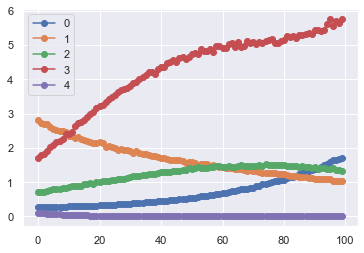

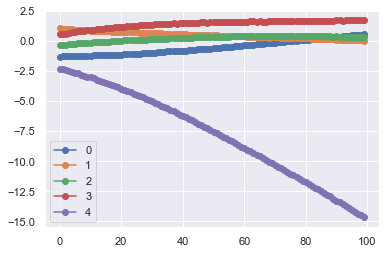

[0.36097839 0.00610368 1.20121486 0.90012163 0.19144814]


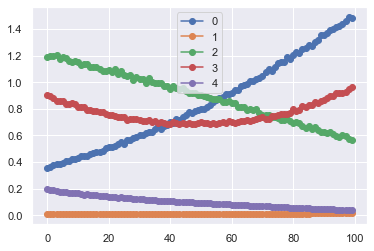

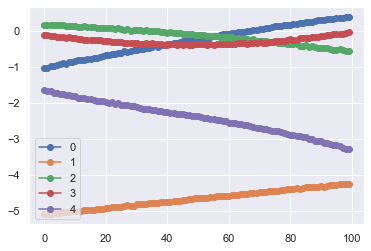

[0.09388381 1.45033192 0.44083743 3.2761404  0.33650105]


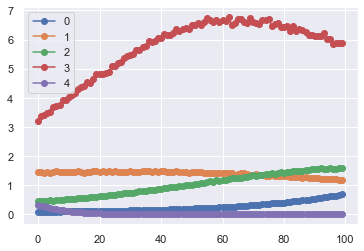

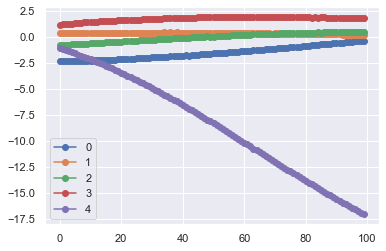

[1.40837681 0.52153801 1.09162678 0.92779866 1.63158289]


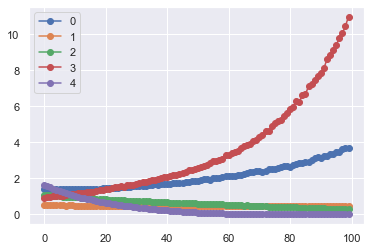

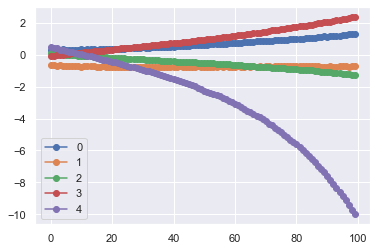

[1.66666188 0.09036842 0.50021239 0.20817563 0.30592932]


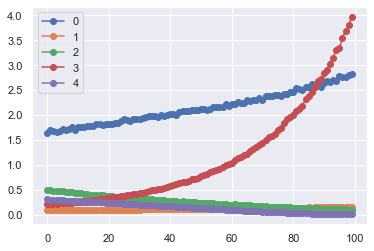

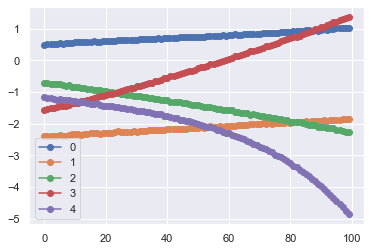

[0.14383525 2.59211868 0.00989157 0.80722408 0.94250935]


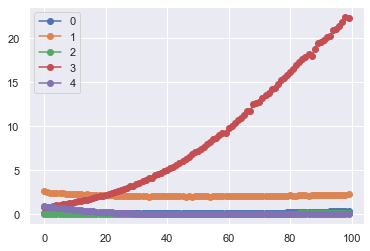

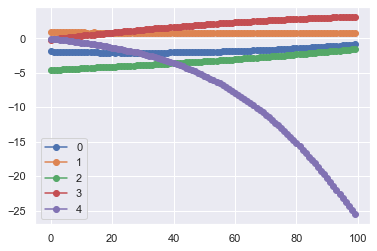

[1.769315   1.01355812 0.50798943 0.32179493 0.69138685]


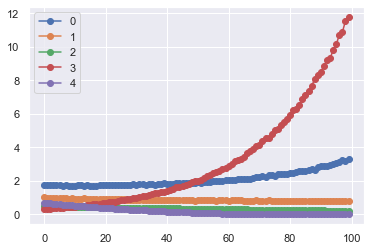

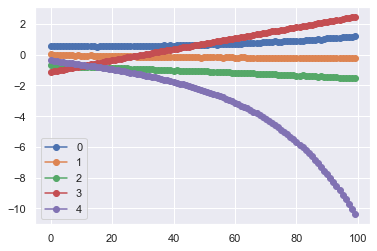

In [452]:
dataset_id, D, step, dt, noize, S, n_day, alpha = 1, 5, 1000, 0.001, 0.01, 7, 100, 0.01
print('N={}'.format(n_day/(step*dt)))
K = 1
phi, timepoint_list, z, x_df, delta_lnx_list, subject_list  = generate_dataset(D, K, 'One-state', dt=dt, 
                                                                               step=step, noize=noize, S=S, 
                                                                               n_day=n_day, alpha=alpha)

In [ ]:
output_dataset(dataset_id, K, step, dt, noize, S, n_day, alpha)

Dataset2

N=100.0
[0.91476702 0.71527626 0.26205617 0.52867711 0.69790854]


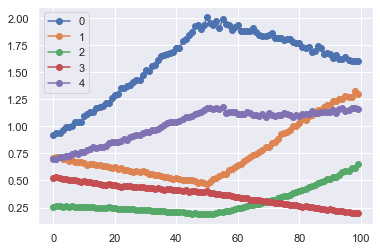

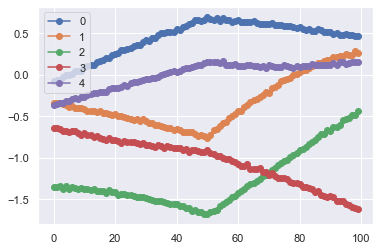

[0.27396829 1.72632062 0.34170028 1.24973219 0.08844825]


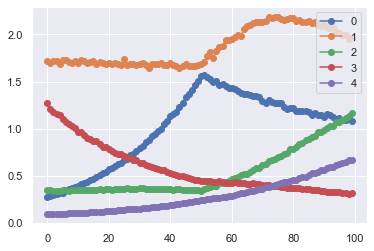

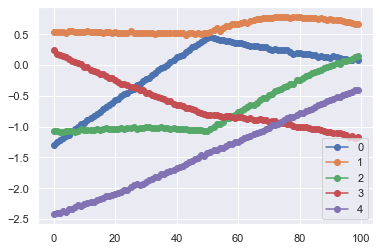

[0.59168499 0.41975237 0.52926805 4.05483356 0.22905283]


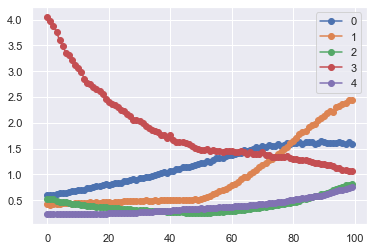

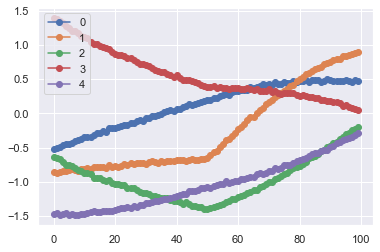

[1.8080558  0.01510653 1.58757378 0.49861307 0.89610947]


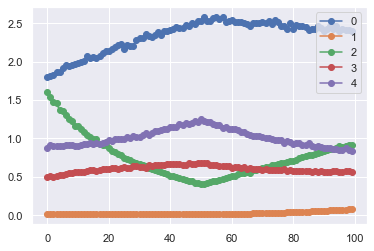

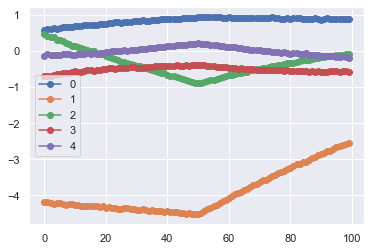

[1.06402543 0.41319205 0.30213846 0.64360736 3.45092189]


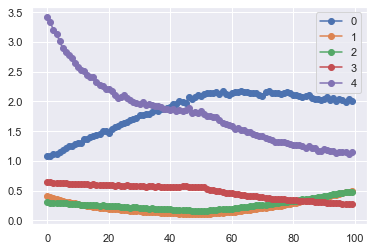

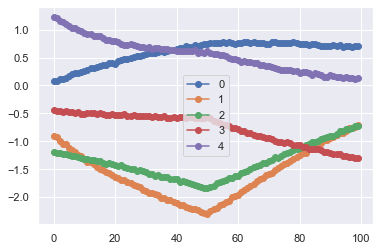

[0.17310269 0.21396667 0.81754142 0.48649696 1.07233006]


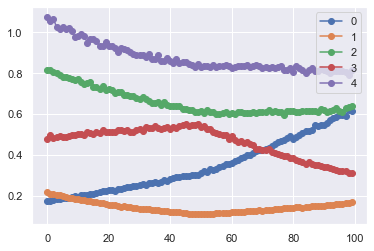

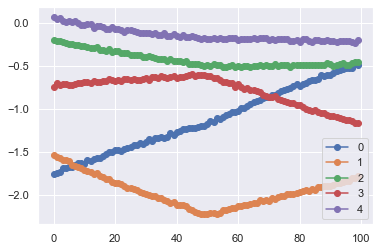

[1.44986207 0.55415131 0.74873084 2.57304549 0.31867029]


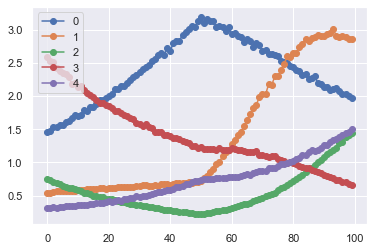

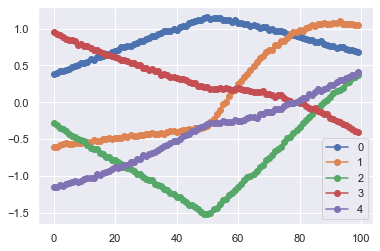

In [466]:
dataset_id, D, step, dt, noize, S, n_day, alpha = 2, 5, 1000, 0.001, 0.01, 7, 100, 0.01
print('N={}'.format(n_day/(step*dt)))
K = 2
phi, timepoint_list, z, x_df, delta_lnx_list, subject_list  = generate_dataset(D, K, 'One-switching', dt=dt, 
                                                                               step=step, noize=noize, S=S, 
                                                                               n_day=n_day, alpha=alpha)

In [ ]:
output_dataset(dataset_id, step, dt, noize, S, n_day, alpha)

Dataset3

N=100.0
[0.2640802  0.24479827 0.69691657 0.40650847 1.36947173 0.70879432
 1.23013224 0.66655117 0.02066303 0.17194853]


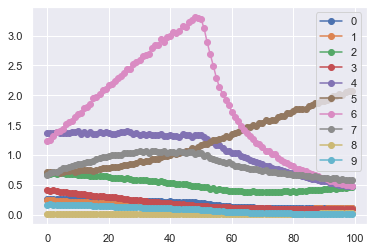

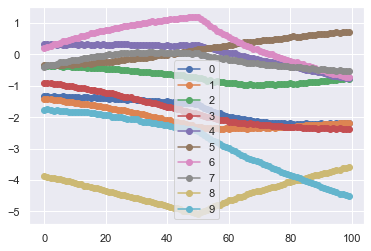

[1.08624004 0.05492632 0.67064243 2.22891802 0.70438542 0.73949735
 0.55088531 0.62935915 0.27655517 0.0610331 ]


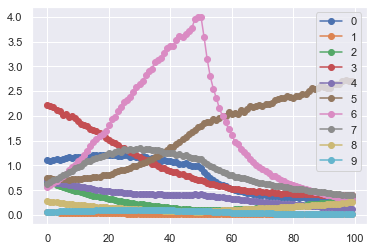

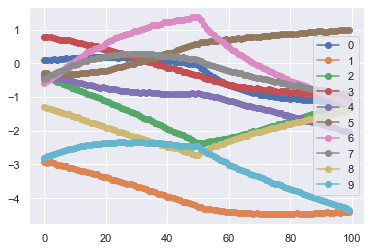

[1.88950295 2.55035509 0.79796408 0.88790324 0.03099199 1.66651644
 1.49965761 0.66667516 0.34288735 0.01309668]


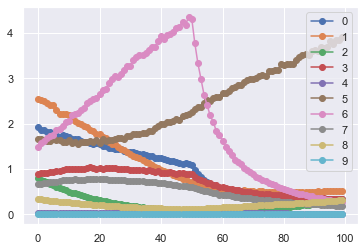

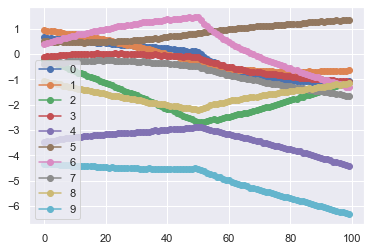

[0.65086424 0.09906456 0.52358402 0.36725182 5.22031939 1.72691973
 0.80305832 0.67320578 0.07842207 0.94947347]


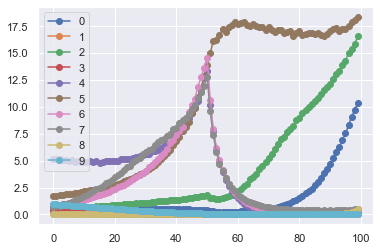

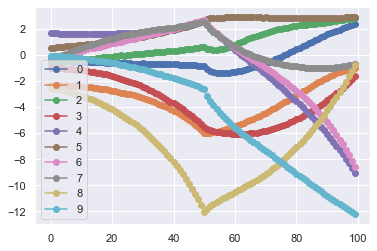

[1.30093701 0.03786599 1.33749301 0.1201702  3.65943046 0.05056797
 0.07155137 1.57786521 1.38876062 0.1963407 ]


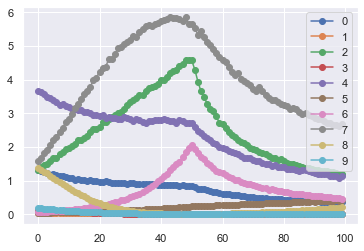

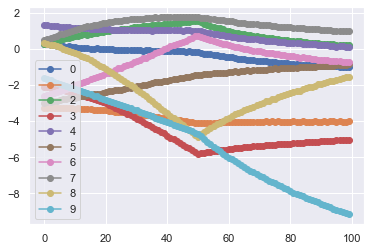

[1.10310785 0.70124001 0.38108231 1.81188952 0.6237392  1.95727256
 0.35296393 0.04924123 0.81810547 0.44235792]


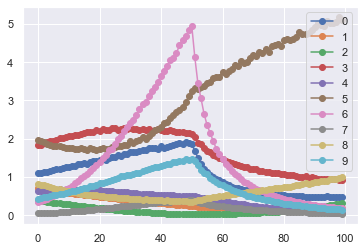

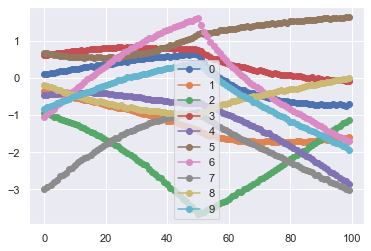

[0.16284477 2.10413377 0.64398534 0.81395646 0.54004317 1.05996883
 1.69791957 0.74912105 1.01388952 1.44193614]


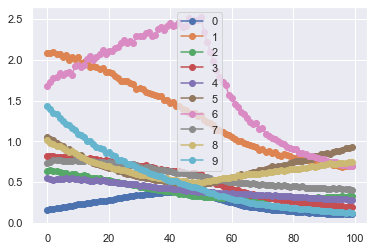

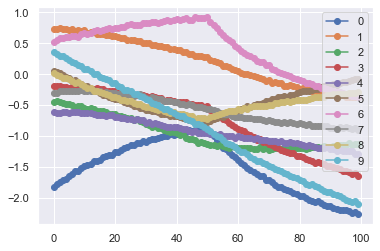

In [503]:
dataset_id, D, step, dt, noize, S, n_day, alpha = 3, 10, 1000, 0.001, 0.01, 7, 100, 0.01
print('N={}'.format(n_day/(step*dt)))
K = 2
phi, timepoint_list, z, x_df, delta_lnx_list, subject_list  = generate_dataset(D, K, 'One-switching', dt=dt, 
                                                                               step=step, noize=noize, S=S, 
                                                                               n_day=n_day, alpha=alpha)

In [ ]:
output_dataset(dataset_id, step, dt, noize, S, n_day, alpha)

### Estimation

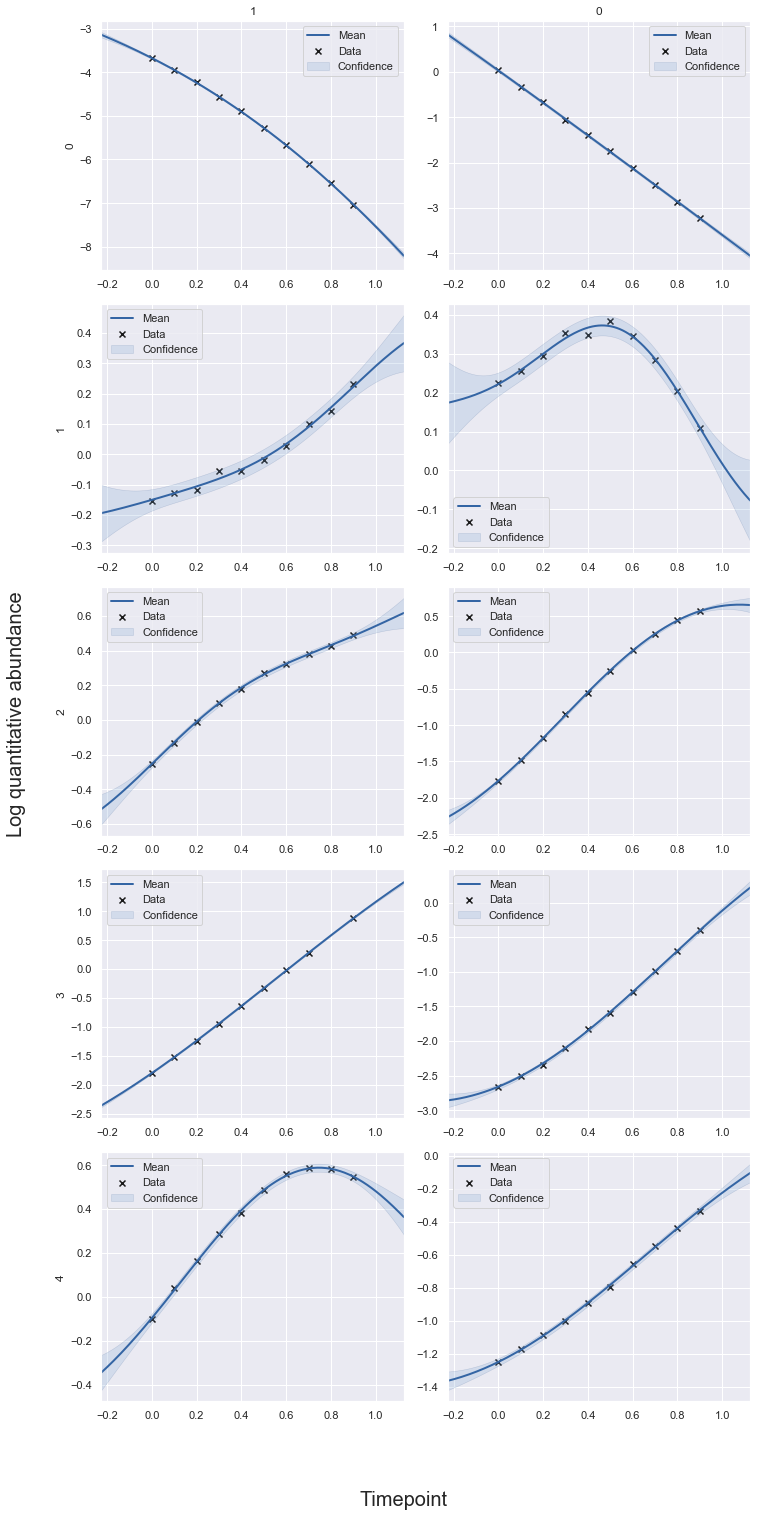

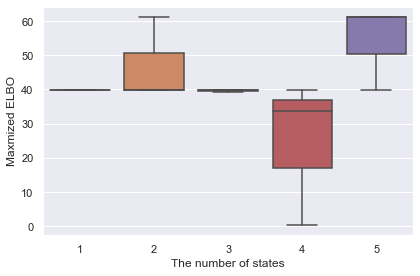

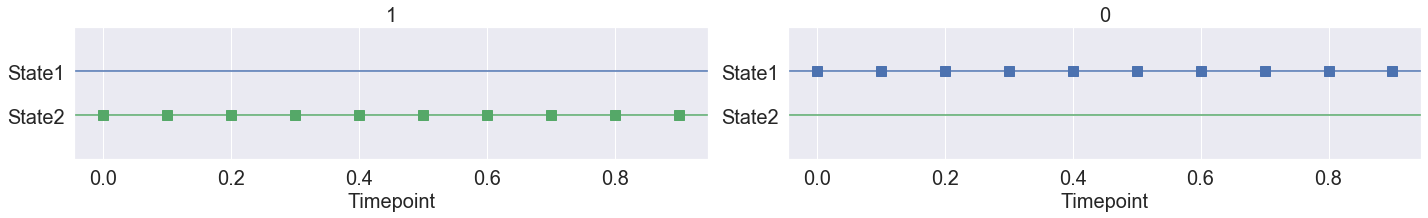

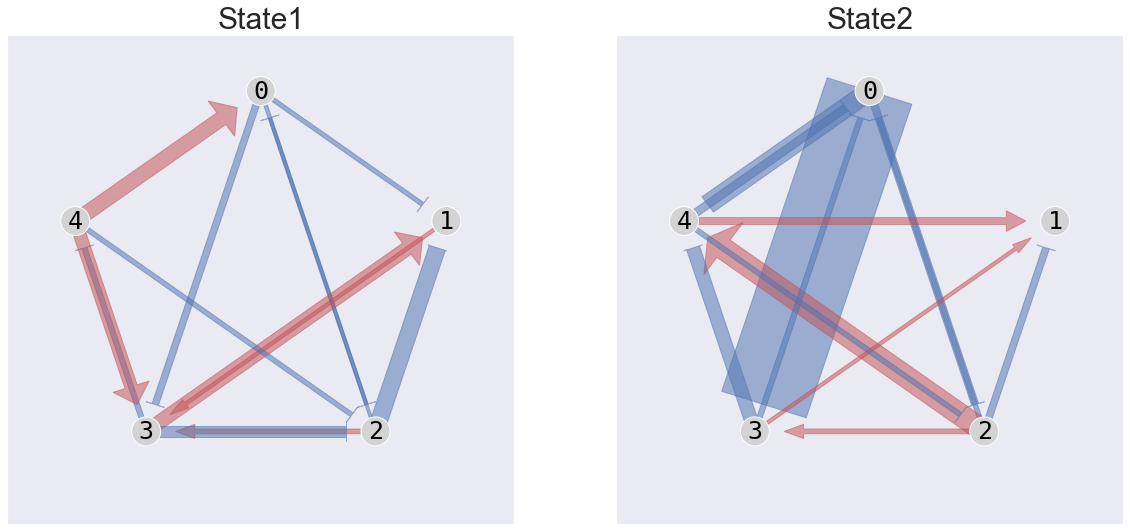

In [114]:
%run ../run_umibato.py ../data/synthetic/Dataset1/x.tsv ../data/synthetic/Dataset1/metadata.tsv 1 5 -i 3 -j 3 -o ../output/synthetic/Dataset1/Practical

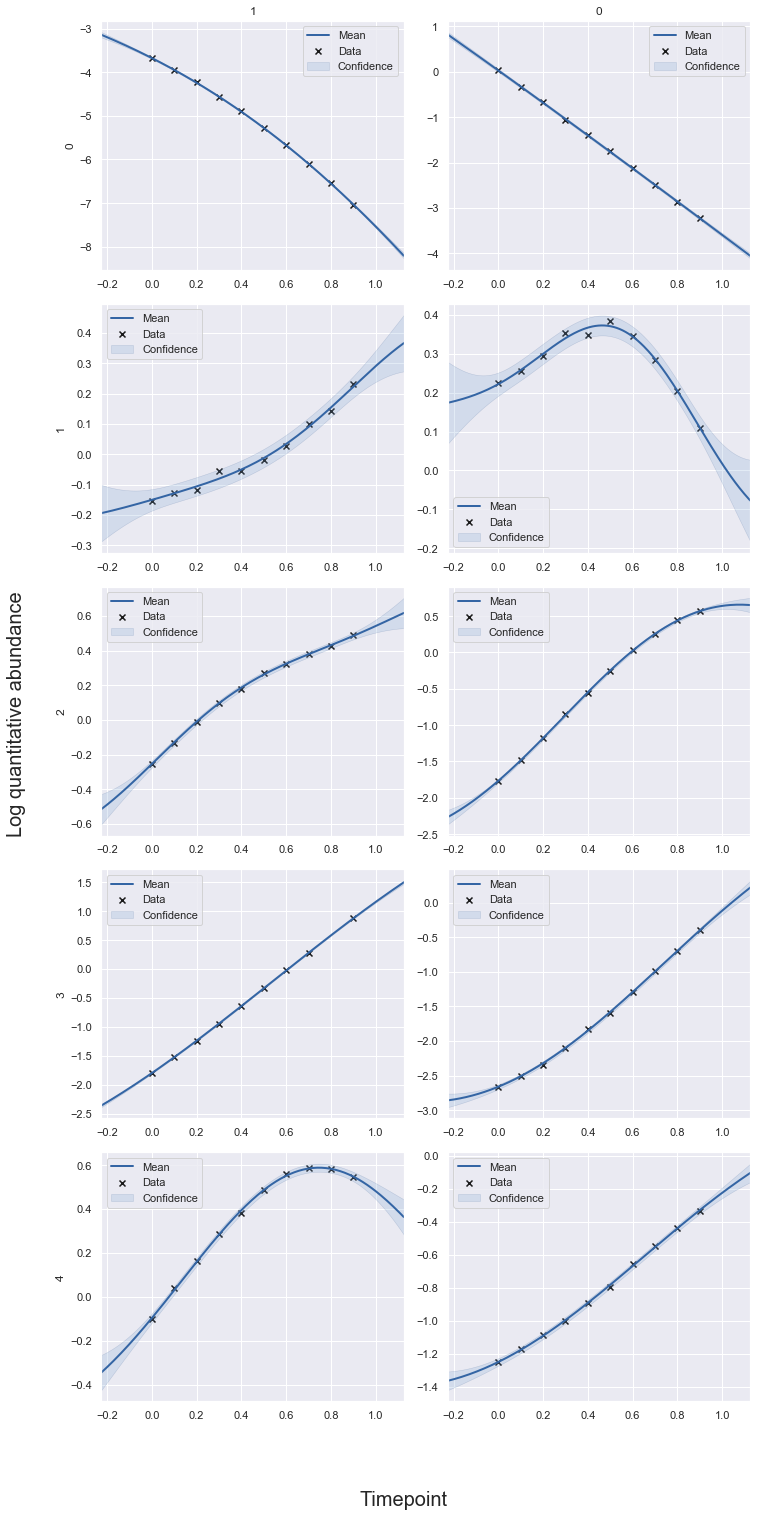

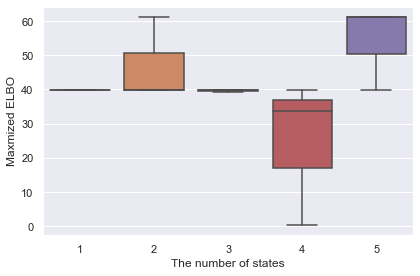

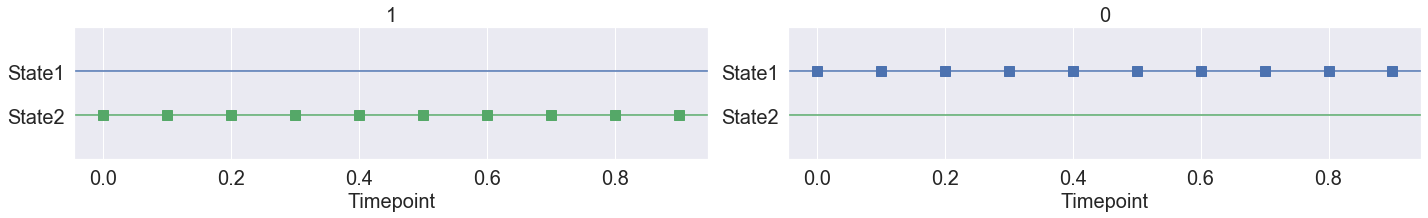

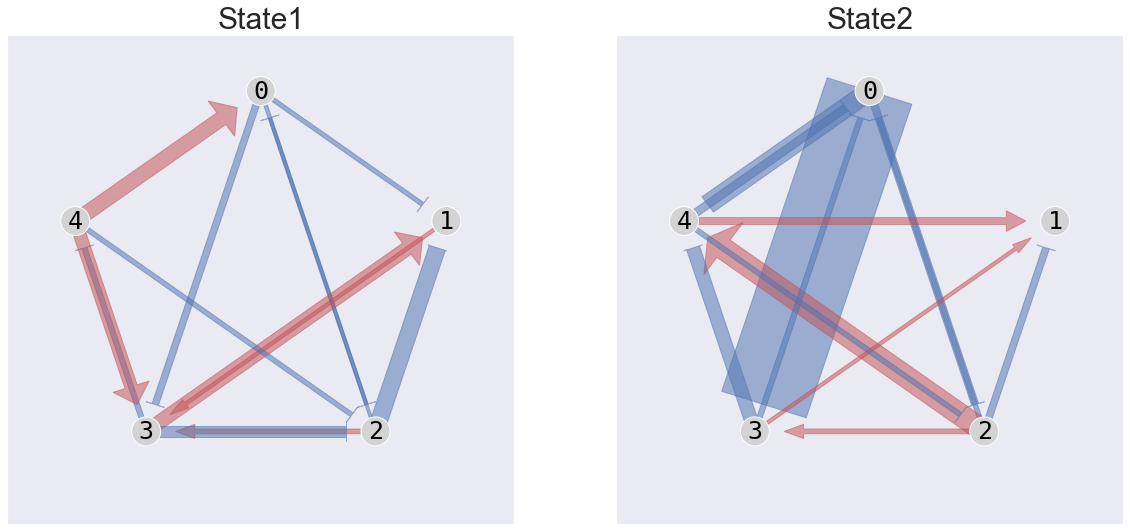

In [114]:
%run ../run_umibato.py ../data/synthetic/Dataset1/x.tsv ../data/synthetic/Dataset1/metadata.tsv 1 1 -i 3 -j 3 -o ../output/synthetic/Dataset1/TrueModel

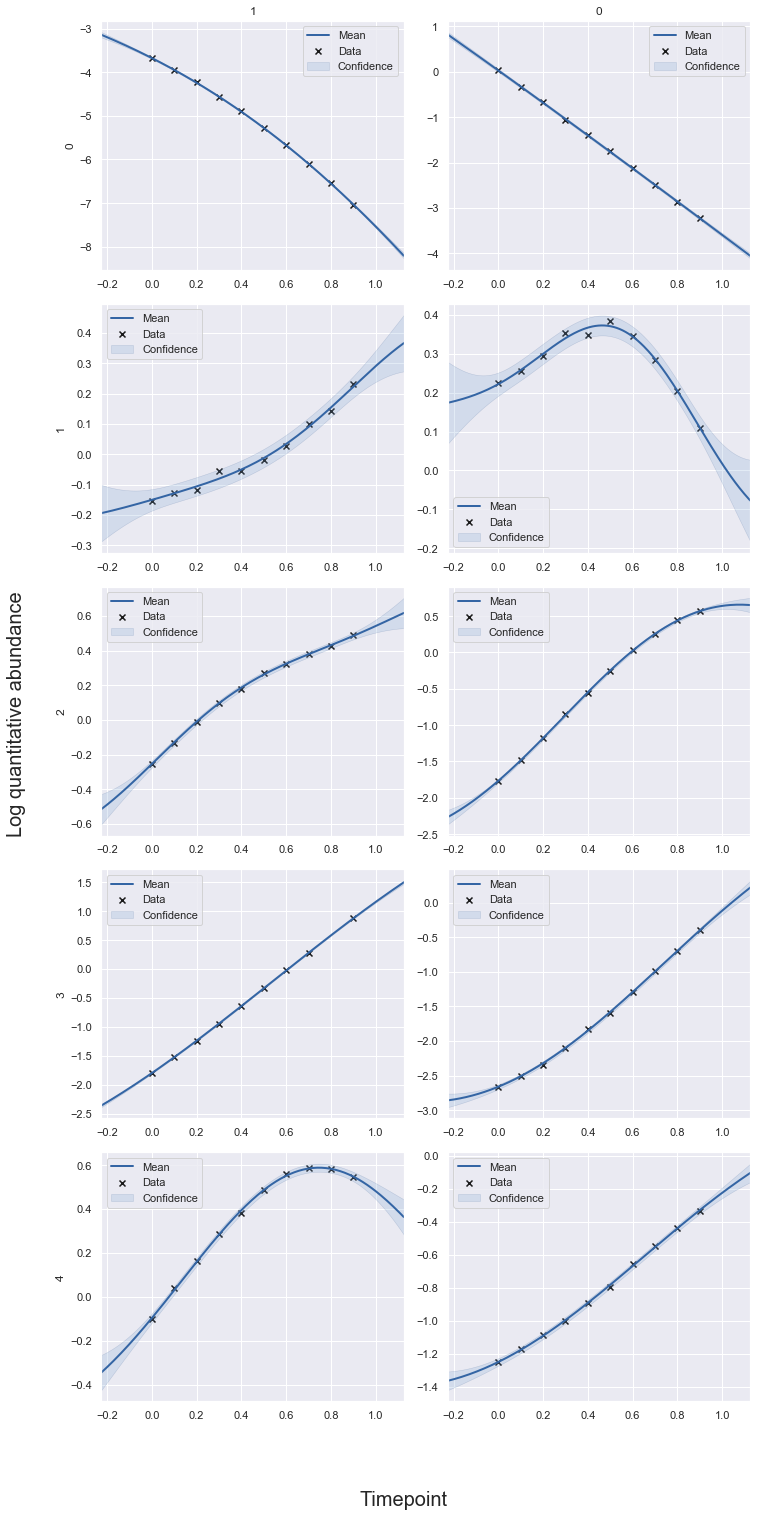

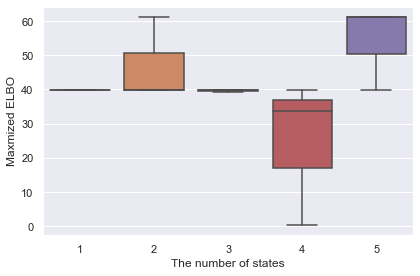

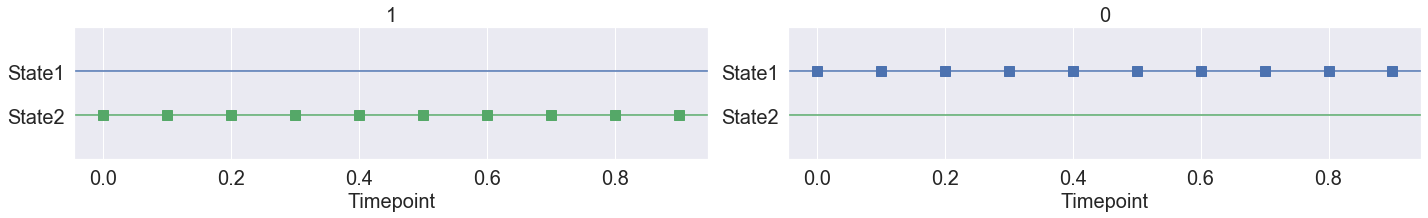

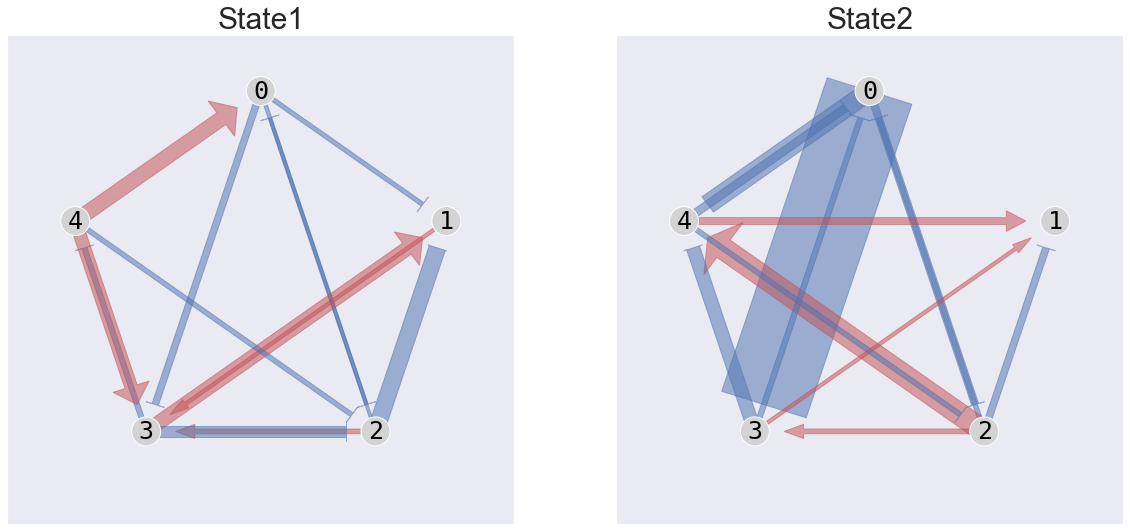

In [114]:
%run ../run_umibato.py ../data/synthetic/Dataset2/x.tsv ../data/synthetic/Dataset2/metadata.tsv 1 5 -i 3 -j 3 -o ../output/synthetic/Dataset2/Practical

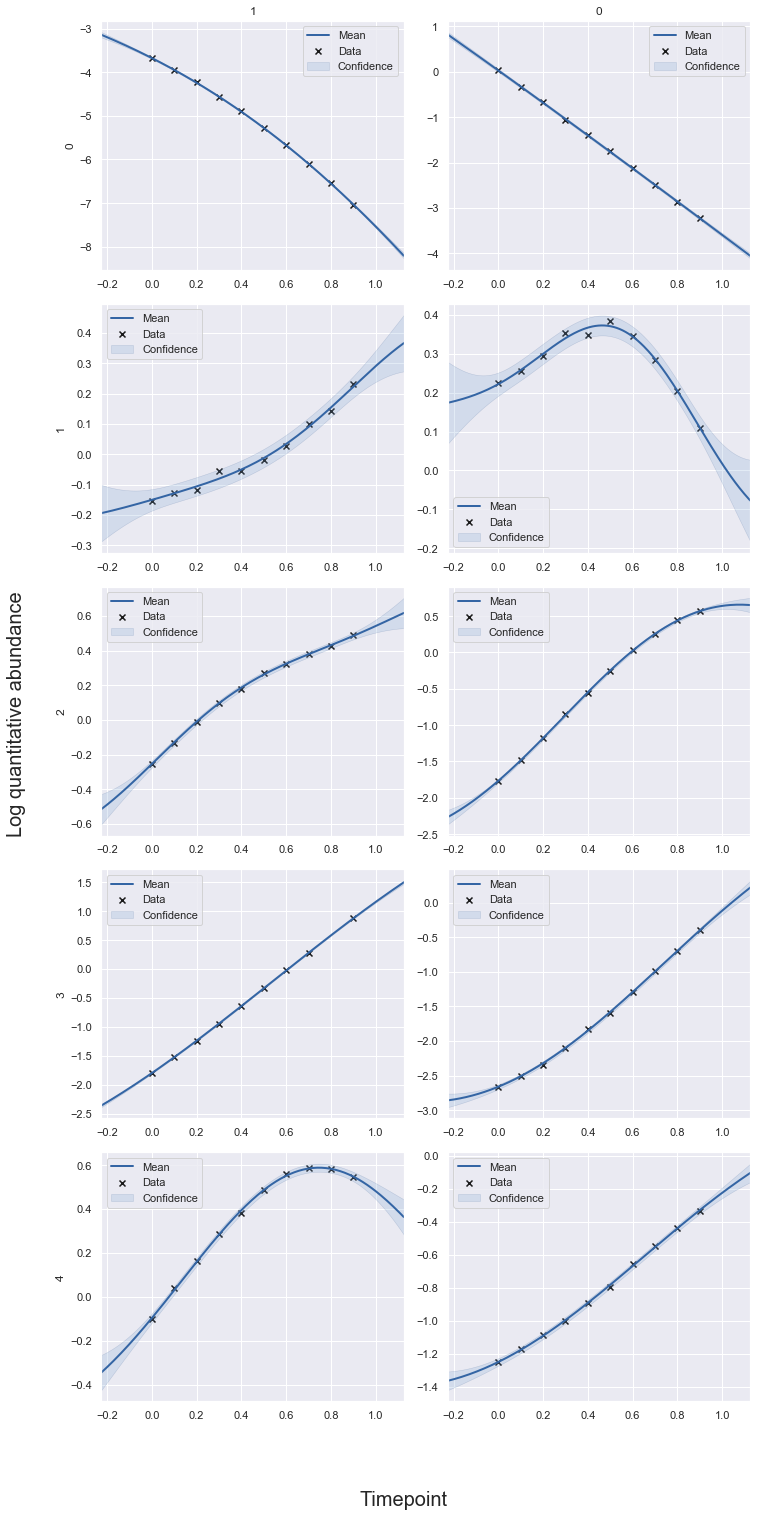

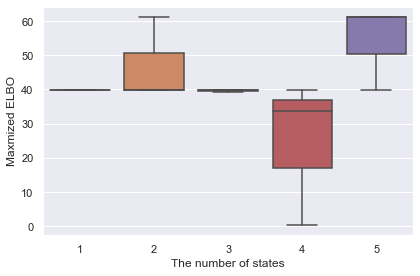

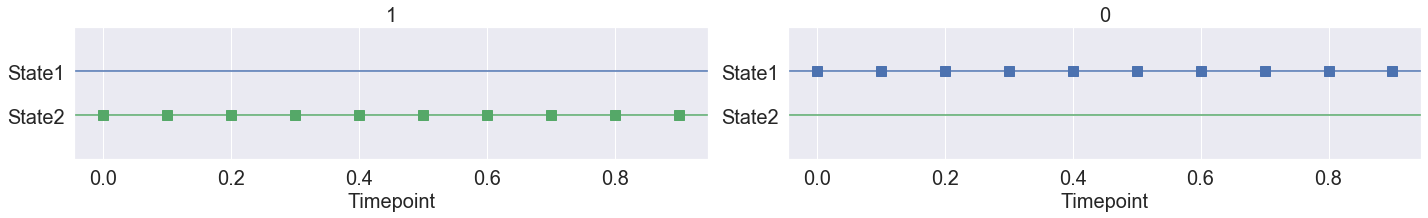

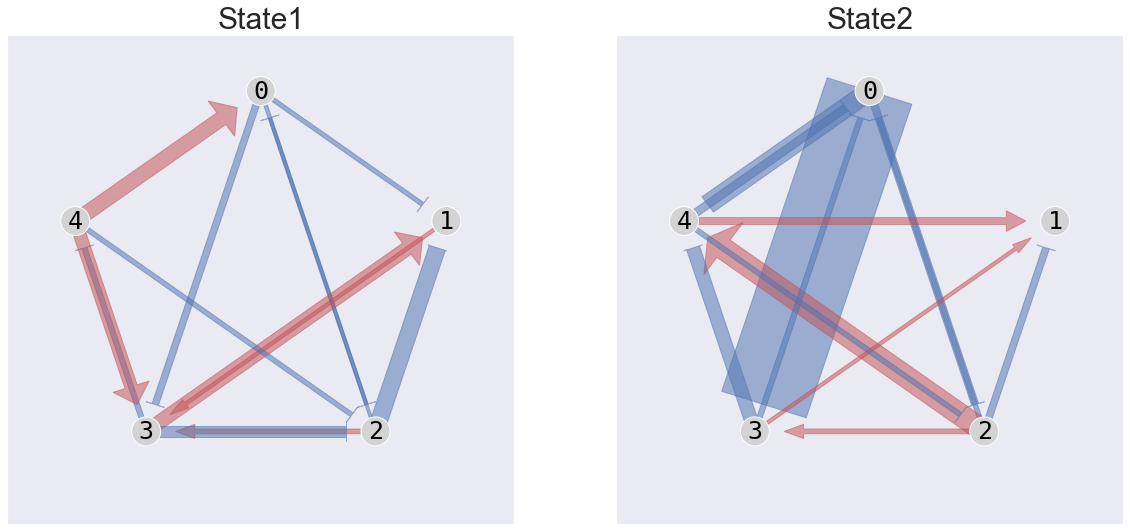

In [114]:
%run ../run_umibato.py ../data/synthetic/Dataset2/x.tsv ../data/synthetic/Dataset2/metadata.tsv 2 2 -i 3 -j 3 -o ../output/synthetic/Dataset2/TrueModel

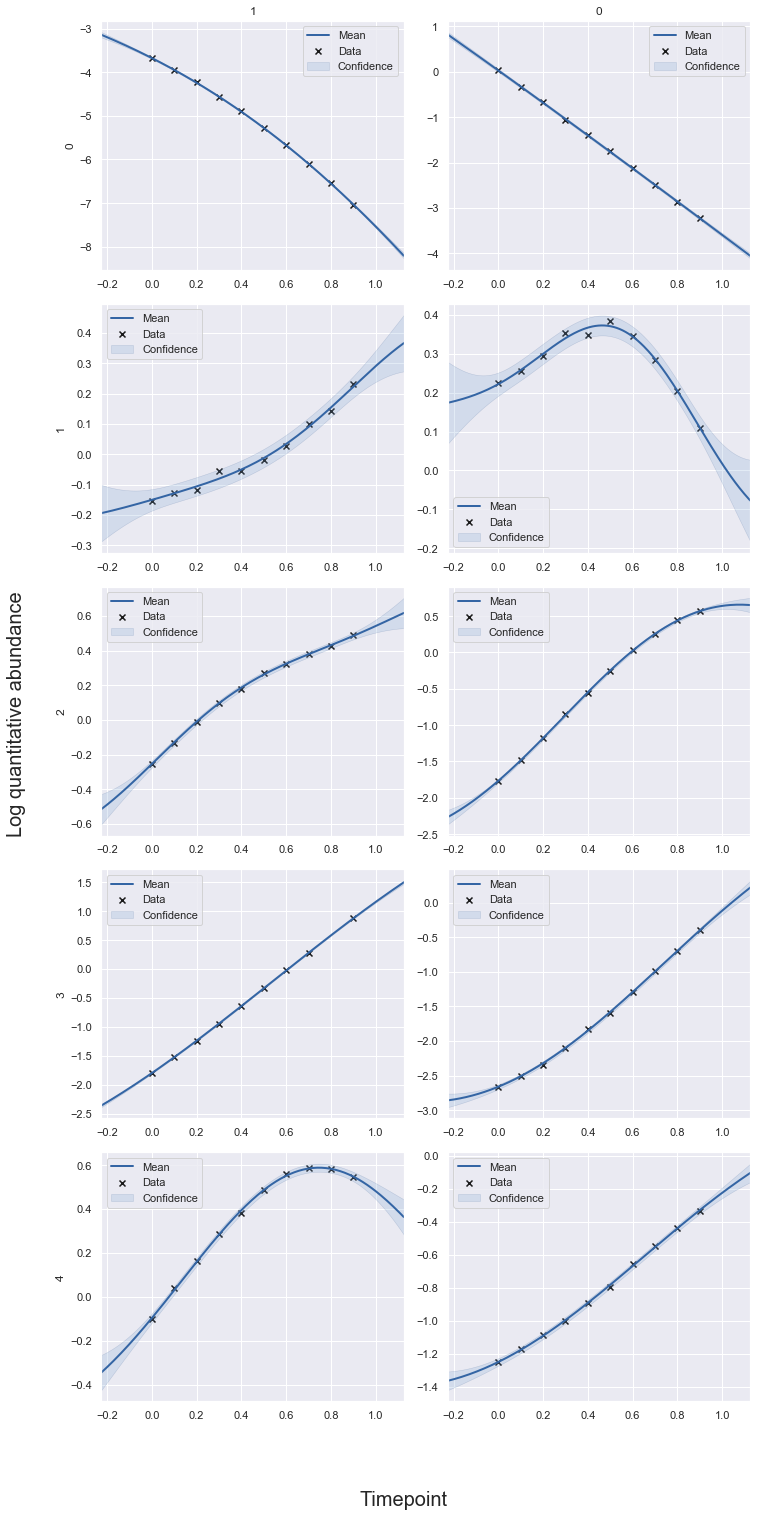

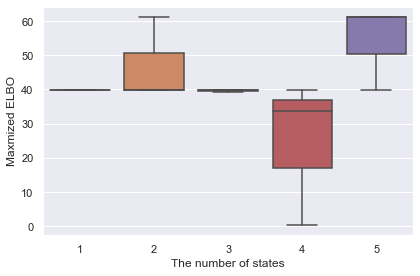

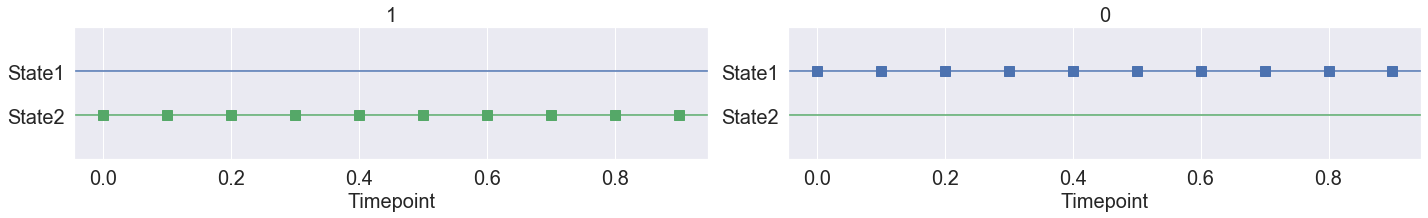

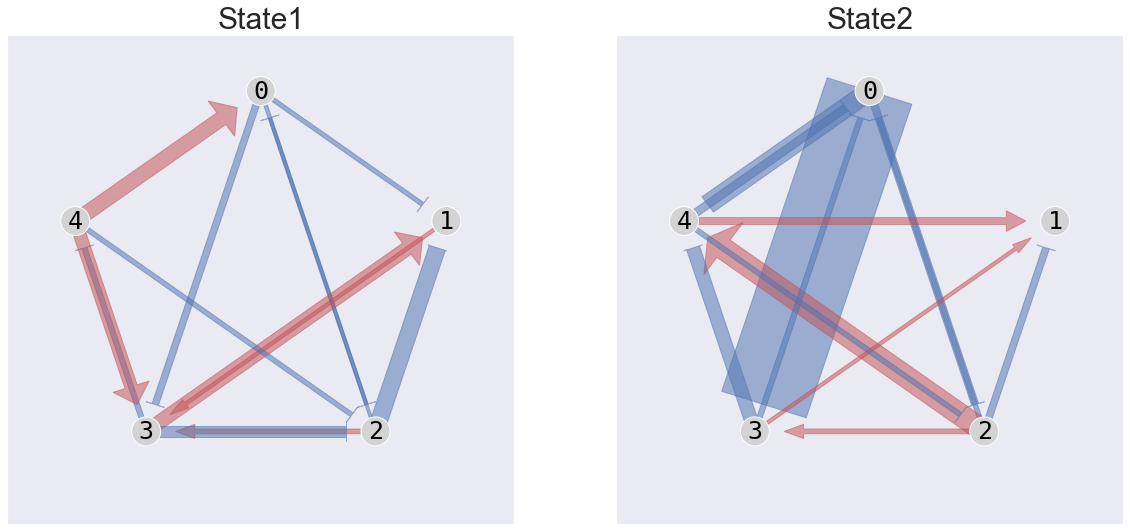

In [114]:
%run ../run_umibato.py ../data/synthetic/Dataset3/x.tsv ../data/synthetic/Dataset3/metadata.tsv 1 5 -i 3 -j 3 -o ../output/synthetic/Dataset3/Practical

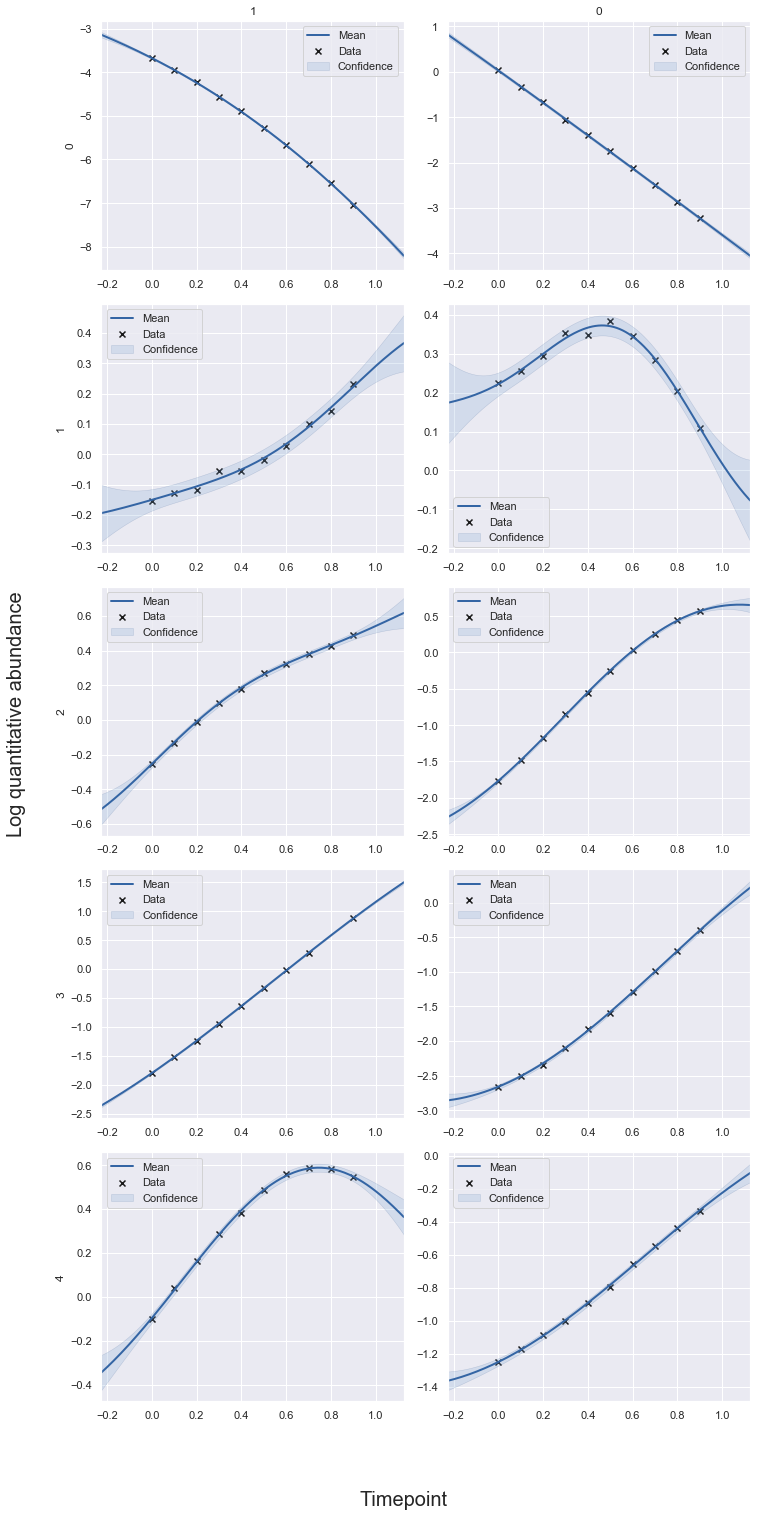

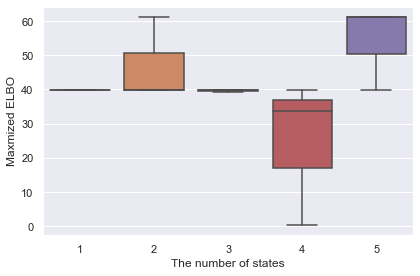

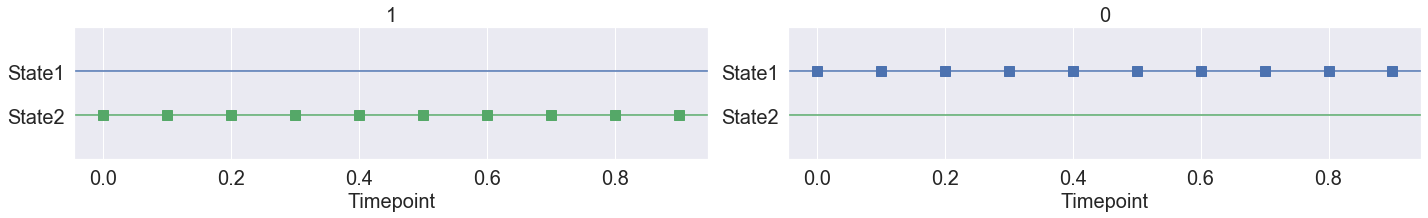

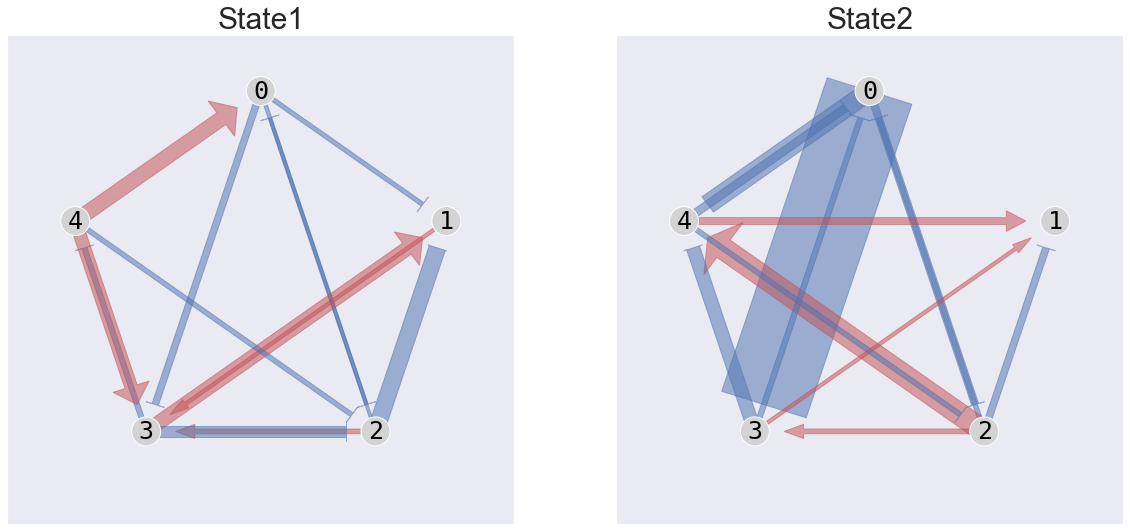

In [114]:
%run ../run_umibato.py ../data/synthetic/Dataset3/x.tsv ../data/synthetic/Dataset3/metadata.tsv 2 2 -i 3 -j 3 -o ../output/synthetic/Dataset3/TrueModel

### Visualization

In [ ]:
# Set True if you have result files of MDSINE.
mdsine_visualized = False
# Set the path of MDSINE (e.g., '../MDSINE-source-code-v1.2')
mdsine_dir = None

def read_mdsine_result(dataset_id, ma_list, D):
    corr_list_list = []
    mean_corr_list = []
    m_est_phi_list = []
    for ma in ma_list:
        m_est_phi = pd.read_csv('{}/output_{}{}/{}.results.parameters.txt'.format(mdsine_dir, dataset_id, ma, ma), 
                                delimiter='\t')[['source_taxon', 'target_taxon', 'value']].fillna(D)
        m_est_phi['source_taxon'] = m_est_phi['source_taxon'].astype(int)
        m_est_phi['target_taxon'] = m_est_phi['target_taxon'].astype(int)
        m_est_phi = m_est_phi.pivot_table(index='source_taxon', columns='target_taxon')
        m_est_phi_list.append(m_est_phi)
    return m_est_phi_list

In [ ]:
def modify_phi(phi, x_raw):
    modified_phi = (phi.iloc[:-1, :].T / x_raw.std(1)).T.copy()
    modified_phi0 = phi.iloc[-1, :] - phi.iloc[:-1, :].T.dot(x_raw.mean(1)/x_raw.std(1))
    modified_phi0.name = 'Growth'
    return modified_phi.append(modified_phi0)

In [7]:
def return_accuracy(metric):
    value_vars = []
    ma_list = ['BAL', 'BVS', 'MLRR', 'MLCRR']
    melt_value_df_list = []
    res_dir = '../output/synthetic'
    value_df = None
    for d, _dataset_id in enumerate([1, 2, 3]):
        for a, true_model_is_used in enumerate([True, False]):
            data_res_dir = None
            if true_model_is_used:
                data_res_dir = '{}/Dataset{}/TrueModel/best_results'.format(res_dir, _dataset_id)
            else:
                data_res_dir = '{}/Dataset{}/Practical/best_results'.format(res_dir, _dataset_id)
            data_path = '../data/synthetic/Dataset{}'.format(_dataset_id)
            step_dt_noize_S_nday = pd.read_csv('{}/step_dt_noize_S_nday.csv'.format(data_path), index_col=0)
            step, dt, _, S, n_day = step_dt_noize_S_nday.loc[:, '0'].tolist()
            step = int(step)
            S = int(S)
            z_df = pd.read_csv('{}/z.tsv'.format(data_path), sep='\t', index_col=0)
            K = len(z_df.iloc[:,0].value_counts().index)
            z = z_df.to_numpy().reshape(-1)
            z_step = z[::step]
            z_step = np.tile(z_step, S)
            x_raw = pd.read_csv('{}/x.tsv'.format(data_path), sep='\t', index_col=0)
            D = len(x_raw.index)
            phi = np.zeros((K, D+1, D))
            for k in range(K):
                phi[k] = pd.read_csv('{}/phi{}.csv'.format(data_path, k), sep='\t', index_col=0)
            viterbi = pd.read_csv('{}/ViterbiPath.csv'.format(data_res_dir), header=None)
            state_list = viterbi[0].value_counts().index.tolist()
            value_list_list = []
            for k_true in range(K):
                value_list = []
                for k in state_list:
                    A = pd.read_csv('{}/phi{}.csv'.format(data_res_dir, k), header=None)
                    A = modify_phi(A, x_raw)
                    value = None
                    if metric == 'spearman':
                        value, _ = spearmanr(A.to_numpy().reshape(-1), phi[k_true].reshape(-1))
                    elif metric == 'pearson':
                        value, _ = pearsonr(A.to_numpy().reshape(-1), phi[k_true].reshape(-1))
                    elif metric == 'mae':
                        value = abs(A.to_numpy().reshape(-1) - phi[k_true].reshape(-1)).mean()
                    # value = np.exp(np.log(abs((A.to_numpy().reshape(-1) - phi[k_true].reshape(-1))/phi[k_true].reshape(-1))
                    #                ).mean())
                    value_list.append(value)
                value_list_list.append(value_list)
            value_cm = pd.DataFrame(value_list_list)
            value_cm.index = range(K)
            value_cm.columns = state_list
            value_list = []
            for true, est in zip(z_step, viterbi.to_numpy().reshape(-1)):
                value_list.append(value_cm.loc[true, est])
            if true_model_is_used:
                method_name = 'Umibato\n(true model)'
            else:
                method_name = 'Umibato (practical)'
            if a == 0:
                value_df = pd.DataFrame(value_list)
                value_df.columns = [method_name]
            else:
                value_df[method_name] = value_list
            value_vars.append(method_name)

        if mdsine_visualized:
            m_est_phi_list = read_mdsine_result(_dataset_id, ma_list, D)
            value_list_list = []
            for k_true in range(K):
                value_list = []
                for m_est_phi in m_est_phi_list:
                    value = None
                    if metric == 'spearman':
                        value, _ = spearmanr(m_est_phi.to_numpy().reshape(-1), phi[k_true].reshape(-1))
                    elif metric == 'pearson':
                        value, _ = pearsonr(m_est_phi.to_numpy().reshape(-1), phi[k_true].reshape(-1))
                    elif metric == 'mae':
                        value = abs(m_est_phi.to_numpy().reshape(-1) - phi[k_true].reshape(-1)).mean()
                    # value = abs((m_est_phi.to_numpy().reshape(-1) - phi[k_true].reshape(-1))/phi[k_true].reshape(-1)).mean()
                    value_list.append(value)
                value_list_list.append(value_list)
            value_cm = pd.DataFrame(value_list_list)
            value_cm.index = range(K)
            value_cm.columns = ma_list
            for ma in ma_list:
                value_list = []
                for true in z_step:
                    value_list.append(value_cm.loc[true, ma])
                method_name = 'MDSINE_{}'.format(ma)
                value_df[method_name] = value_list
                value_vars.append(method_name)

        melt_value_df = value_df.melt(value_vars=value_vars,
                                  var_name='Method', value_name='value')
        melt_value_df['Dataset'] = 'Dataset{}'.format(_dataset_id)
        melt_value_df_list.append(melt_value_df)

    cnct_melt_value_df = pd.concat(melt_value_df_list)
    return cnct_melt_value_df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


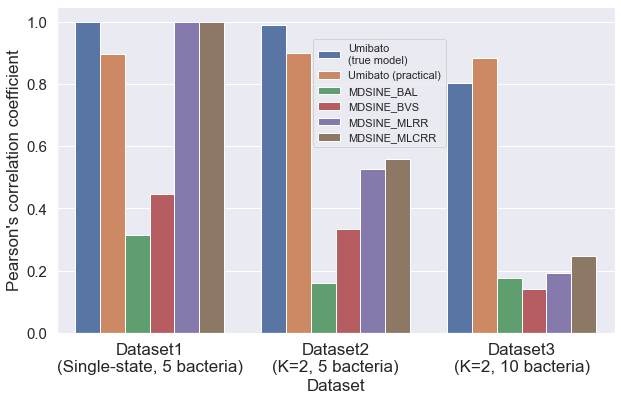

In [11]:
cnct_melt_value_df = return_accuracy('pearson')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=cnct_melt_value_df, x='Dataset', hue='Method', 
            y='value', ax=ax, ci=None)
plt.sca(ax)
plt.legend(bbox_to_anchor=(0.460, 0.9), loc='upper left', borderaxespad=0, fontsize=11)
plt.ylabel('Pearson\'s correlation coefficient', fontsize=17)
plt.xlabel('Dataset', fontsize=17)
plt.yticks(fontsize=17)
plt.xticks([0, 1, 2], ['Dataset1\n(Single-state, 5 bacteria)', 
                       'Dataset2\n(K=2, 5 bacteria)', 
                       'Dataset3\n(K=2, 10 bacteria)'], fontsize=17)
plt.yticks(fontsize=15)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


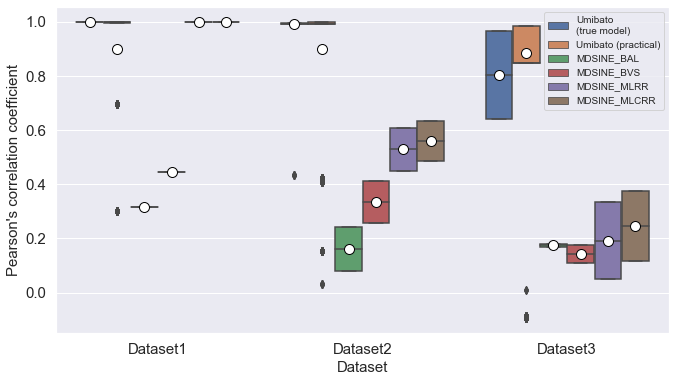

In [12]:
cnct_melt_value_df = return_accuracy('pearson')
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
plt.sca(ax)
meanprops={"marker":"o",
           "markerfacecolor":"white", 
           "markeredgecolor":"black",
           "markersize":"10"}
sns.boxplot(data=cnct_melt_value_df, x='Dataset', hue='Method', 
            y='value', showmeans=True, meanprops=meanprops, ax=ax)
plt.ylabel('Pearson\'s correlation coefficient', fontsize=15)
# plt.legend(bbox_to_anchor=(0.465, 0.9), loc='upper left', borderaxespad=0, fontsize=11)
plt.legend(fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Dataset', fontsize=15)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


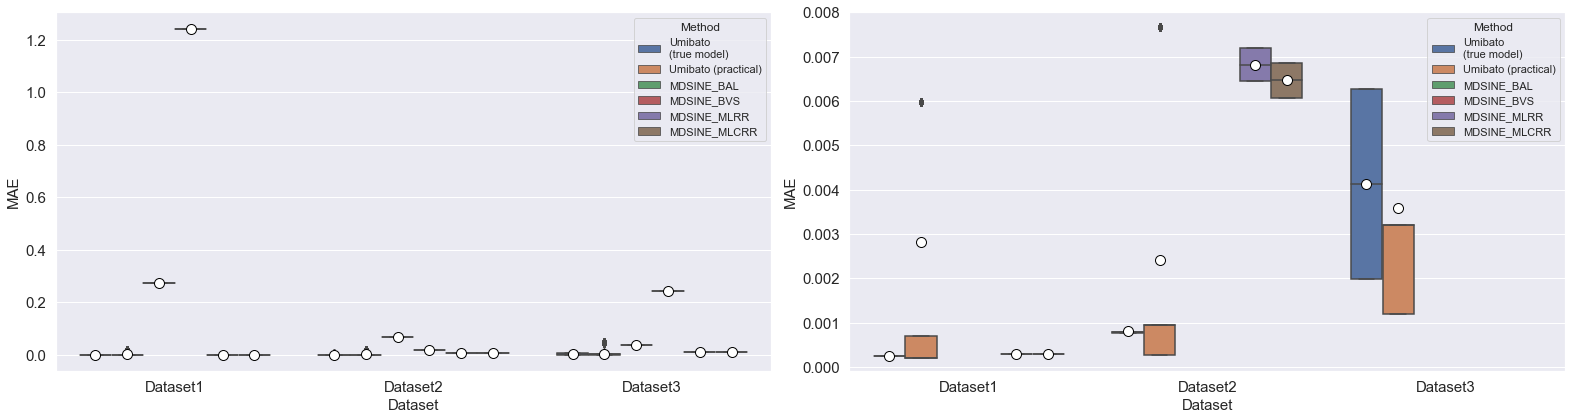

In [13]:
cnct_melt_value_df = return_accuracy('mae')
fig, axes = plt.subplots(1, 2, figsize=(22, 6))
ax = axes[0]
plt.sca(ax)
meanprops={"marker":"o",
           "markerfacecolor":"white", 
           "markeredgecolor":"black",
           "markersize":"10"}
sns.boxplot(data=cnct_melt_value_df, x='Dataset', hue='Method', 
            y='value', showmeans=True, meanprops=meanprops, ax=ax)
plt.ylabel('MAE', fontsize=15)
# plt.legend(bbox_to_anchor=(0.465, 0.9), loc='upper left', borderaxespad=0, fontsize=11)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Dataset', fontsize=15)
ax = axes[1]
plt.sca(ax)
sns.boxplot(data=cnct_melt_value_df, x='Dataset', hue='Method', 
            y='value', showmeans=True, meanprops=meanprops, ax=ax)
plt.ylabel('MAE', fontsize=15)
# plt.legend(bbox_to_anchor=(0.465, 0.9), loc='upper left', borderaxespad=0, fontsize=11)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Dataset', fontsize=15)
plt.ylim([-0.0001,0.008])
plt.tight_layout()
plt.show()

In [45]:
cnct_melt_value_df.groupby(['Dataset', 'Method']).mean()

value
Dataset  Method                         
Dataset1 MDSINE_BAL             0.315934
         MDSINE_BVS             0.445230
         MDSINE_MLCRR           0.999426
         MDSINE_MLRR            0.999426
         Umibato\n(true model)  0.999127
         Umibato (real)         0.898154
Dataset2 MDSINE_BAL             0.160739
         MDSINE_BVS             0.334424
         MDSINE_MLCRR           0.558729
         MDSINE_MLRR            0.528350
         Umibato\n(true model)  0.991621
         Umibato (real)         0.901333
Dataset3 MDSINE_BAL             0.174753
         MDSINE_BVS             0.141983
         MDSINE_MLCRR           0.246442
         MDSINE_MLRR            0.191690
         Umibato\n(true model)  0.802813
         Umibato (real)         0.885395

Confusion matrix

In [57]:
res_dir = '../output/synthetic'
df_list = []
for is_real_case in [False, True]:
    for d, _dataset_id in enumerate([2, 3]):
        data_res_dir = None
        if is_real_case:
            data_res_dir = '{}/Dataset{}/Practical/best_results'.format(res_dir, _dataset_id)
        else:
            data_res_dir = '{}/Dataset{}/TrueModel/best_results'.format(res_dir, _dataset_id)
        data_path = '../data/synthetic/Dataset{}'.format(_dataset_id)
        step_dt_noize_S_nday = pd.read_csv('{}/step_dt_noize_S_nday.csv'.format(data_path), index_col=0)
        step, dt, _, S, n_day = step_dt_noize_S_nday.loc[:, '0'].tolist()
        step = int(step)
        S = int(S)
        z_df = pd.read_csv('{}/z.tsv'.format(data_path), sep='\t', index_col=0)
        z = z_df.to_numpy().reshape(-1)
        z_step = z[::step]
        z_step = np.tile(z_step, S)
        df_for_cm = pd.read_csv('{}/ViterbiPath.csv'.format(data_res_dir), header=None)
        df_for_cm.columns = ['Estimated']
        df_for_cm['True'] = z_step
        df_list.append(df_for_cm)

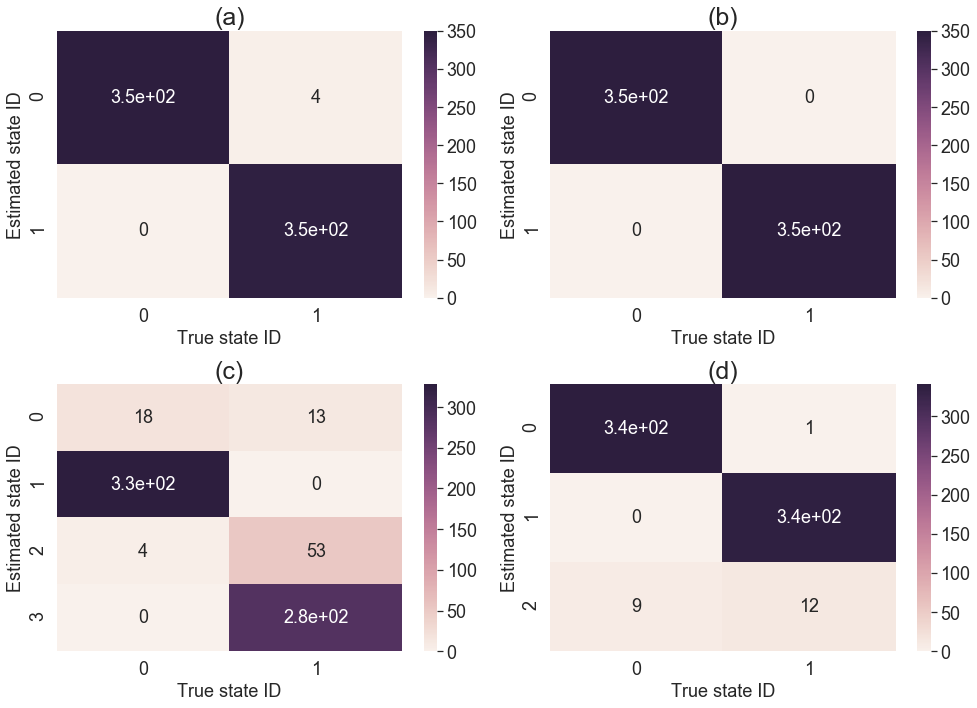

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(13.9, 10))
titlesize = 25
labelsize = 18
cellfontsize = 18
title_list = ['(a)', '(b)', '(c)', '(d)']
for i, (title, df) in enumerate(zip(title_list, df_list)):
    ax = axes[i//2][i%2]
    ax.set_title(title, fontsize=titlesize)
    sns.heatmap(pd.crosstab(df['True'], df['Estimated']).T,
                ax=ax, cmap=sns.cubehelix_palette(light=.95, as_cmap=True), 
                annot=True, annot_kws={"fontsize":cellfontsize})
    ax.set_ylabel('Estimated state ID', fontsize=labelsize)
    ax.set_xlabel('True state ID', fontsize=labelsize)
    plt.sca(ax)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=labelsize)
plt.tight_layout()
plt.show()